In [188]:
import numpy as np
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import torch
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
from sklearn.metrics import f1_score
from torchvision.datasets import CIFAR10

In [189]:
#Convert the dataset into Tensor used by PyTorch
transform=transforms.Compose([
         transforms.ToTensor(),
        ])

#Download the MINST data directly from PyTorch
#The downloaded datasets are stored in the same folder with this jupyter notebook file
#For train dataset, use "train=True"
#For test dataset, use "train=False"
train_dataset = datasets.CIFAR10('./data', train=True, download=True, transform=transform)
test_dataset = datasets.CIFAR10('./data', train=False, download=True, transform=transform)

#Load the datasets into DataLoader
train_dataloader = DataLoader(train_dataset, batch_size=64, shuffle=True, num_workers=0)
test_dataloader = DataLoader(test_dataset, batch_size=64, shuffle=False, num_workers=0)

class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer',
               'dog', 'frog', 'horse', 'ship', 'truck']

Files already downloaded and verified
Files already downloaded and verified


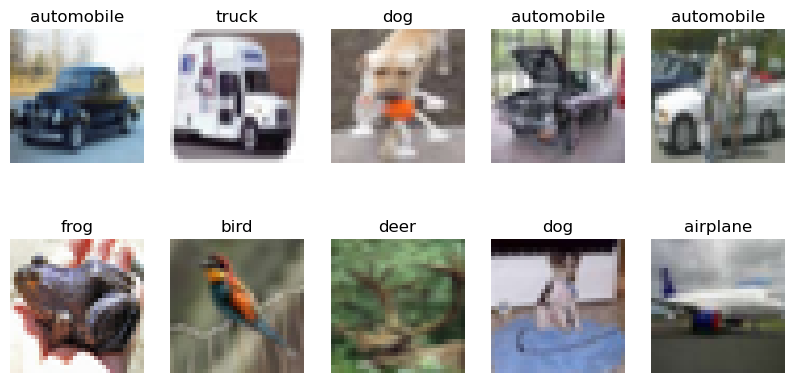

In [190]:
import matplotlib as mpl
import matplotlib.pyplot as plt
def plot_images(instances, labels, images_per_row=5):
    for i in range(len(instances)):
        idx = i // images_per_row
        idy = i % images_per_row 
        ax[idx, idy].imshow(instances[i].permute(1, 2, 0))
        ax[idx, idy].set_title(class_names[labels[i]])
        ax[idx, idy].axis("off")
dataiter = iter(train_dataloader)
samples = next(dataiter)
fig, ax = plt.subplots(2, 5, figsize=(10, 5))
dataiter = iter(train_dataloader)
samples = next(dataiter)
example_images = samples[0][:10]
example_labels = samples[1][:10]

plot_images(example_images, example_labels, images_per_row=5)
plt.show()

In [191]:
#Pre-define the training function
def train(cnn_model, optimizer, lossfunction, epoch, train_dataloader):
    cnn_model.train()
    
    running_loss = 2.0
    train_total, train_correct = 0.0, 0.0    
    y_train, y_pred = [], []
    
    for i, (features, labels) in enumerate(train_dataloader):
        optimizer.zero_grad()

        outputs = cnn_model(features)

        loss = lossfunction(outputs, labels.long())
        loss.backward()
        optimizer.step()
        
        #print statistics
        running_loss += loss.item()
        _, train_predicted = torch.max(outputs.data, 1)
        train_total += labels.size(0)
        train_correct += (train_predicted == labels.long()).sum().item()
        y_train += labels.tolist()
        y_pred += train_predicted.tolist()
        
        if i % 200 == 0:
            print('Epoch: {} [{}/{} ({:.0f}%)]\tloss: {:.6f}'.format(
                epoch, i * len(features), len(train_dataloader.dataset),
                100. * i / len(train_dataloader), loss.item()))

    macro_f1 = f1_score(y_train, y_pred, average='macro')
    print("epoch (%d): Train accuracy: %.4f, f1_score: %.4f, loss: %.3f" % (epoch, train_correct/train_total, macro_f1, running_loss/train_total))
 

#Pre-define the test function
def test(cnn_model, test_dataloader):
    cnn_model.eval()
    
    test_correct, test_total = 0.0, 0.0
    y_test, y_pred = [], []
    
    with torch.no_grad():
        for features, labels in test_dataloader:
            outputs = cnn_model(features)
            
            _, predicted = torch.max(outputs.data, 1)
            test_total += labels.size(0)
            test_correct += (predicted == labels.long()).sum().item()
            y_test += labels.tolist()
            y_pred += predicted.tolist()
    test_accuracy = test_correct / test_total
    macro_f1 = f1_score(y_test, y_pred, average='macro')
    print('The test accuracy is: %.4f' % (test_correct / test_total))
    print('macro f1_score is: %.4f' % macro_f1)
    return y_test, y_pred
    

In [192]:
import torch
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import matplotlib as mpl
import matplotlib.pyplot as plt
np.random.seed(42)
torch.manual_seed(42)

#Set up some hyperparameters
epochs = 10                         #Based on your computing resources, assign epochs as a number in the range of [5, 10]
learning_rate = 0.01
weight_decay = 5e-4
lossfunction = nn.CrossEntropyLoss()

#Define a class ClassificationNet to construct all the layers in the convolutional neural network
import torch.nn as nn
import torch.nn.functional as F

class ClassificationNet(nn.Module):
    def __init__(self):
        super(ClassificationNet, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.fc1 = nn.Linear(128 * 4 * 4, 512)  
        self.fc2 = nn.Linear(512, 10)           
        self.dropout = nn.Dropout(0.5)
        self.pool = nn.MaxPool2d(2, 2)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        x = x.view(-1, 128 * 4 * 4)
        x = self.dropout(F.relu(self.fc1(x)))
        x = self.fc2(x)
        return x
def before_attack(): 
    model =  ClassificationNet()
    optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9, weight_decay=5e-4)
    for epoch in range(1, epochs + 1):
        train(model, optimizer, lossfunction, epoch, train_dataloader)
    y_test, y_pred = test(model, test_dataloader) 
    return model

#Run your function in the cell to return the results
model = before_attack()
#print("The number of epochs you used for CNN training is:", epochs)


Epoch: 1 [0/50000 (0%)]	loss: 2.302165
Epoch: 1 [12800/50000 (26%)]	loss: 2.059524
Epoch: 1 [25600/50000 (51%)]	loss: 2.035575
Epoch: 1 [38400/50000 (77%)]	loss: 1.693616
epoch (1): Train accuracy: 0.2587, f1_score: 0.2441, loss: 0.031
Epoch: 2 [0/50000 (0%)]	loss: 1.756710
Epoch: 2 [12800/50000 (26%)]	loss: 1.428523
Epoch: 2 [25600/50000 (51%)]	loss: 1.329353
Epoch: 2 [38400/50000 (77%)]	loss: 1.217821
epoch (2): Train accuracy: 0.4683, f1_score: 0.4632, loss: 0.023
Epoch: 3 [0/50000 (0%)]	loss: 1.315117
Epoch: 3 [12800/50000 (26%)]	loss: 1.481476
Epoch: 3 [25600/50000 (51%)]	loss: 1.439291
Epoch: 3 [38400/50000 (77%)]	loss: 1.193157
epoch (3): Train accuracy: 0.5637, f1_score: 0.5613, loss: 0.019
Epoch: 4 [0/50000 (0%)]	loss: 1.019061
Epoch: 4 [12800/50000 (26%)]	loss: 1.096601
Epoch: 4 [25600/50000 (51%)]	loss: 1.091890
Epoch: 4 [38400/50000 (77%)]	loss: 1.485517
epoch (4): Train accuracy: 0.6285, f1_score: 0.6272, loss: 0.017
Epoch: 5 [0/50000 (0%)]	loss: 1.014149
Epoch: 5 [12800/5

In [193]:
def fgsm_attack(image, epsilon, image_input_grad):
    #Obtain the sign of the gradient
    sign_grad = image_input_grad.sign()
    
    #Generate the perturbed image by adding the perturbation with size of epsilon and direction of gradient to the input image
    perturbed_image = image + epsilon * sign_grad
    perturbation = epsilon * sign_grad
    
    #Each pixel value's range is [0,1]
    #After performing adversarial attack, the pixel values may go out of boundary
    #Add clipping to maintain [0,1] range
    perturbed_image = torch.clamp(perturbed_image, 0, 1)
    
    #Return the perturbed image
    return perturbed_image, perturbation

In [194]:
def perform_attack(epsilon, image_input, image_label):
    #Set requires_grad attribute of tensor as true, which will be used for Attack
    image_input.requires_grad = True

    output = model(image_input)

    init_pred = output.max(1, keepdim=True)[1]

    #if init_pred.tolist() != class_names.tolist():
        #print("The predicted label and the true label are different. Please choose another image input for attack!")

    #Calculate the loss
    loss = lossfunction(output, image_label.long())

    # Zero all existing gradients
    model.zero_grad()

    #Calculate gradients of loss in backward pass
    loss.backward()

    #Obtain the gradient regarding input image
    image_input_grad = image_input.grad.data

    # Call FGSM attack
    perturbed_image, perturbation = fgsm_attack(image_input, epsilon, image_input_grad)

    # Re-classify the perturbed image
    adv_output = model(perturbed_image)

    adv_pred = adv_output.max(1, keepdim=True)[1]

    return perturbed_image, perturbation, init_pred, adv_pred

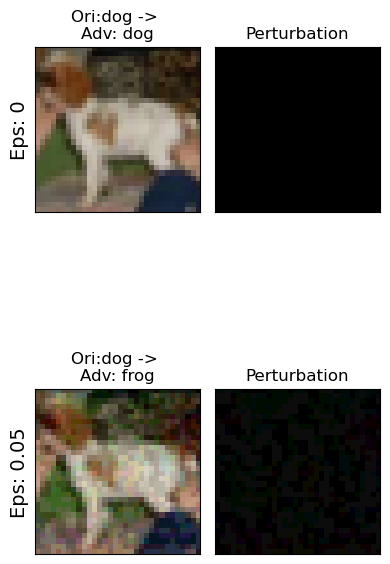

(32, 32, 3)


In [195]:

#epsilons
epsilons = [0, 0.05]

#Choose a random image as input
image_sample_index = 12

dataiter = iter(test_dataloader)
samples = next(dataiter)
image_input, image_label = samples[0][image_sample_index:image_sample_index+1], samples[1][image_sample_index:image_sample_index+1]

adversarial_examples = []
adv_preds = []
init_preds = []
perturbations = []

for epsilon in epsilons:
    perturbed_image, perturbation, init_pred, adv_pred = perform_attack(epsilon, image_input, image_label)
    adversarial_examples.append(perturbed_image.squeeze().detach().numpy())
    adv_preds.append(adv_pred.item())
    init_preds.append(init_pred.item())
    perturbations.append(perturbation.squeeze().detach().numpy())

#Plot adversarial example and the perturbation at each epsilon
cnt = 0
plt.figure(figsize=(4,8))
for i in range(len(epsilons)):
    cnt = 2 * i + 1 
    plt.subplot(len(epsilons), 2, cnt)
    plt.xticks([], [])
    plt.yticks([], [])
    plt.ylabel("Eps: {}".format(epsilons[i]), fontsize=14)
    orig, adv, ex = init_preds[i], adv_preds[i], adversarial_examples[i] 
    ex = np.transpose(ex, (1, 2, 0))    
    plt.title("Ori:{} -> \nAdv: {}".format(class_names[orig], class_names[adv]))
    plt.imshow(ex,  vmin=0, vmax=255)
    
    plt.subplot(len(epsilons), 2, cnt+1)
    plt.xticks([], [])
    plt.yticks([], [])
    perturbation = perturbations[i] 
    perturbation = np.transpose(perturbation, (1, 2, 0))
    plt.title("Perturbation".format(orig, adv))
    perturbation = np.clip(perturbation, 0, 1)
    plt.imshow(perturbation, vmin=0, vmax=255)
plt.tight_layout()
plt.show()
print(ex.shape)

In [196]:
from torch.utils.data import TensorDataset

def after_attack():
    adversarial_images = []
    adversarial_labels = []
    
    #Generare a set of adversarial examples by performing attacks over the original test images
    for image_input, image_label in test_dataloader:
        #Call perform_attack() function to generate perturbed images
        perturbed_images, _, init_pred, adv_pred=  perform_attack(epsilon, image_input, image_label)
        #Append the perturbed_images to the list of adversarial_images
        adversarial_images.append(perturbed_images)
        #Append the image_labels to the list of adversarial_labels
        adversarial_labels.append(image_label)
    
    #Concanate a list of adversarial_images to torch Tensor
    adversarial_images = torch.cat(adversarial_images).detach()
    #Concanate a list of adversarial_labels to torch Tensor
    adversarial_labels = torch.cat(adversarial_labels).detach()
    
    #Construct adversarial training dataset
    adv_dataset = TensorDataset(adversarial_images, adversarial_labels)
    
    #Load the datasets into DataLoader
    adv_dataloader = DataLoader(adv_dataset, batch_size=64, shuffle=False, num_workers=0)
    
    #Test the original model using adv_dataloader
    #Call test() function here: the model should be the original one, and the test data should be adv_dataloader
    y_test, y_pred = test(model, adv_dataloader)
    
    return adv_dataloader, adv_dataset
        

#Run your function in the cell to return the results
adv_dataloader, adv_dataset = after_attack()

The test accuracy is: 0.0108
macro f1_score is: 0.0114


In [197]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision.utils import save_image
torch.manual_seed(47)

# Generator network
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.fc = nn.Linear(1, 512)  
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(512, 32 * 32 * 3) 

    def forward(self, x):
        x = self.relu(self.fc(x))
        x = torch.sigmoid(self.fc2(x))
        return x


# Discriminator network
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.fc1 = nn.Linear(32 * 32 * 3, 512)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(512, 1)  # Output size 1 for binary classification

    def forward(self, x):
        x = x.view(x.size(0), -1)  # Flatten input tensor
        x = self.relu(self.fc1(x))
        x = torch.sigmoid(self.fc2(x))  # Using sigmoid for binary classification
        return x

def APEGAN():
    for epoch in range(1, epochs + 1):
        for i, (adversarial_images, _) in enumerate(test_dataloader):
            valid = torch.ones(adversarial_images.size(0), 1)
            generator = Generator()
            discriminator = Discriminator()
            adversarial_loss = nn.BCELoss()
            mse_loss = nn.MSELoss()  # Mean Squared Error Loss
            optimizer_G = optim.SGD(generator.parameters(), lr=0.01, momentum=0.9, weight_decay=5e-4)
            optimizer_D = optim.SGD(discriminator.parameters(), lr=0.01, momentum=0.9, weight_decay=5e-4)
            optimizer_G.zero_grad()
            z = torch.randn(adversarial_images.size(0), 1)
            gen_images = generator(z) #Passing adversarial_images to the generator to generate new gen_images
            real_output = discriminator(image_input) #real_output is generated using the input images
            fake_output = discriminator(gen_images.detach())  # Detach to avoid backprop through Generator           
            # Calculate loss for Discriminator
            real_loss = adversarial_loss(real_output, torch.ones_like(real_output))
            fake_loss = adversarial_loss(fake_output, torch.zeros_like(fake_output))
           
            g_loss = mse_loss(discriminator(gen_images), valid)
            # g_loss += adversarial_loss(fake_output)
            g_loss.backward() 
            optimizer_G.step()
            optimizer_D.zero_grad()
            d_loss = (real_loss + fake_loss) / 2
            d_loss.backward()
            optimizer_D.step()
        
            if i % 100 == 0:
                print(
                     "[Epoch %d]  [D loss: %f] [G loss: %f]"
                     % (epoch, d_loss.item(), g_loss.item())
                )

    correct_real = (real_output > 0.5).sum().item()  # Number of correctly classified real images
    correct_fake = (fake_output < 0.5).sum().item()  # Number of correctly classified fake images
    total_real = real_output.size(0)  # Total number of real images
    total_fake = fake_output.size(0)  # Total number of fake images
        
        # Calculate accuracy
    accuracy = (correct_real + correct_fake) / (total_real + total_fake)

    return accuracy

accuracy = APEGAN()
print("Test Accuracy {:.4f}".format(accuracy))


[Epoch 1]  [D loss: 0.719130] [G loss: 0.250825]
[Epoch 1]  [D loss: 0.701257] [G loss: 0.266364]
[Epoch 2]  [D loss: 0.686663] [G loss: 0.241031]
[Epoch 2]  [D loss: 0.715068] [G loss: 0.229370]
[Epoch 3]  [D loss: 0.705987] [G loss: 0.258296]
[Epoch 3]  [D loss: 0.675551] [G loss: 0.280484]
[Epoch 4]  [D loss: 0.709423] [G loss: 0.222734]
[Epoch 4]  [D loss: 0.694873] [G loss: 0.270086]
[Epoch 5]  [D loss: 0.701895] [G loss: 0.251155]
[Epoch 5]  [D loss: 0.728382] [G loss: 0.193982]
[Epoch 6]  [D loss: 0.685610] [G loss: 0.257357]
[Epoch 6]  [D loss: 0.690659] [G loss: 0.237758]
[Epoch 7]  [D loss: 0.679738] [G loss: 0.320059]
[Epoch 7]  [D loss: 0.710757] [G loss: 0.256912]
[Epoch 8]  [D loss: 0.696147] [G loss: 0.235628]
[Epoch 8]  [D loss: 0.681350] [G loss: 0.258218]
[Epoch 9]  [D loss: 0.695173] [G loss: 0.241113]
[Epoch 9]  [D loss: 0.719002] [G loss: 0.257582]
[Epoch 10]  [D loss: 0.709354] [G loss: 0.196408]
[Epoch 10]  [D loss: 0.699066] [G loss: 0.314036]
Test Accuracy 0.94

In [1]:
a='*' 
for i in range (5): 
    print(a) 
    a= a+'*'

*
**
***
****
*****
